In [149]:
import cvrplib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
font = {
    'family' : 'arial',
    'weight' : 'bold',
    'size'   : 15
}
plt.rc('font', **font)
plt.rcParams["figure.figsize"] = (10,8)


class AntColonySolver:
    
    def __init__(self,    
                 iterations=100, 
                 ants = 5, 
                 alpha=1, 
                 beta=1, 
                 sigma=1, 
                 q=0.8, 
                 theta=80):
        
        self.iterations = iterations
        self.ants = ants
        self.alpha = alpha # Здесь alpha это не скорость испарения, а величина, определяющая «жадность» алгоритма
        self.beta = beta
        self.sigma = sigma
        self.q = q
        self.theta = theta
        
    def fit(self, folder, dataset, verbose=False, early_stop=None):
        instance, solution = cvrplib.read(instance_path=f"{folder}{dataset}.vrp",
                                          solution_path=f"{folder}{dataset}.sol")
        self.bench_routes = solution.routes
        self.bench_cost = solution.cost
        self.graph = {i+1: instance.coordinates[i] for i in range(instance.n_customers+1)}
        self.demand = {i+1: instance.demands[i] for i in range(instance.n_customers+1)}
        self.capacity = instance.capacity
        distances = instance.distances
        customers = list(self.graph.keys())
        self.vertices = customers[1:]
        self.edges = {(min(a,b),max(a,b)): distances[a-1][b-1] for a in customers for b in customers if a!=b}
        self.feromones = {(min(a,b),max(a,b)): 1 for a in customers for b in customers if a!=b}
        self.solve(verbose, early_stop)
    
    def one_ant_solution(self) -> list:
        solution = []
        vertices = self.vertices.copy()
        capacity_limit = self.capacity

        while vertices:
            path = []
            city = np.random.choice(vertices)
            capacity = capacity_limit - self.demand[city]
            path.append(city)
            vertices.remove(city)

            while vertices:
                prob_sum = 0
                probabilities = []

                for v in vertices:
                    prob = ((self.feromones[(min(v,city), max(v,city))])**self.alpha) * \
                           ((1/self.get_edges(v, city))**self.beta) if self.get_edges(v, city) != 0 else 0
                    probabilities.append(prob)
                    prob_sum += prob

                probabilities = [p/prob_sum for p in probabilities]
                city = np.random.choice(vertices, p=probabilities)
                capacity -= self.demand[city]

                if capacity >= 0:
                    path.append(city)
                    vertices.remove(city)
                else:
                    break

            solution.append(path)

        return solution
    
    def get_edges(self, a, b):
        key = (min(a, b), max(a, b))
        dist = self.edges.get(key, 0)
        return dist or 1
    
    def solution_cost(self, solution) -> int:
        cost = 0
        for route in solution:
            start = 1
            for node in route:
                cost += self.get_edges(start, node)
                start = node
            cost += self.get_edges(start, 1)
        return cost
    
    def get_feromones(self, path, i) -> tuple:
        node_a, node_b = path[i], path[i+1]
        if node_a < node_b:
            return (node_a, node_b)
        else:
            return (node_b, node_a)
        
    def update_feromone(self, solutions, best_solution) -> int:
        path_lengths = [solution[1] for solution in solutions]
        L_mean = sum(path_lengths) / len(solutions)

        pheromone_update = lambda v: (self.q + self.theta / L_mean) * v
        self.feromones = {k: pheromone_update(v) for k, v in self.feromones.items()}

        solutions.sort(key=lambda x: x[1])
        if best_solution is None or solutions[0][1] < best_solution[1]:
            best_solution = solutions[0]

        sigma_update = lambda v: self.sigma / best_solution[1] + v
        for path in best_solution[0]:
            for i in range(len(path) - 1):
                self.feromones[self.get_feromones(path, i)] = sigma_update(self.feromones[self.get_feromones(path, i)])

        for l, (paths, L) in enumerate(solutions):
            for path in paths:
                for i in range(len(path) - 1):
                    decay_factor = self.sigma - (l + 1) / L ** (l + 1)
                    self.feromones[self.get_feromones(path, i)] += decay_factor

        return best_solution
    
    def solve(self, verbose=None, early_stop=None):
        self.best_solution = None
        prev_solution = None
        stop = 0
        i = 0
        while i < self.iterations:
            solutions = [self.one_ant_solution() for _ in range(self.ants)]
            solutions_with_costs = [(s, self.solution_cost(s)) for s in solutions]
            self.best_solution = self.update_feromone(solutions_with_costs, self.best_solution)
            if verbose and i % verbose == 0:
                print(f"{i}: {int(self.best_solution[1])}")
            if prev_solution == self.best_solution:
                stop += 1
                if early_stop and stop == early_stop:
                    break
            else:
                stop = 0
                prev_solution = self.best_solution
            i += 1
    
    def get_best_solution(self) -> tuple:
        routes = [[node-1 for node in route] for route in self.best_solution[0]]
        cost = self.best_solution[1]
        return (routes, cost)
    
    def evaluate_solution(self) -> float:
        improvement = self.best_solution[1] - self.bench_cost
        relative_improvement = improvement / self.bench_cost
        return round(relative_improvement, 3)
    
    def plot_solution_routes(self):
        bench_routes = [[e+1 for e in route] for route in self.bench_routes]
        solution_routes = self.best_solution[0]

        self.plot_routes(bench_routes, title="Bench plot")
        self.plot_routes(solution_routes, title="Solution plot")

    def score(self):
        if self.best_solution is None:
            return None
        return self.best_solution[1]
    
    def plot_routes(self, routes, title="Routes"):
        fig, ax = plt.subplots()
        ax.set_title(title)

        for i, sol in enumerate(routes):
            x = [self.graph[1][0]] + [self.graph[n][0] for n in sol] + [self.graph[1][0]]
            y = [self.graph[1][1]] + [self.graph[n][1] for n in sol] + [self.graph[1][1]]

            ax.plot(x, y, label=f"Route {i+1}")

        ax.legend()
        plt.show()

In [151]:
# from sklearn.model_selection import GridSearchCV
# С гридсерчем возникли проблемы, поэтому придется вручную
folder = "E/"
dataset = "E-n22-k4"

for a in [0.5, 1, 2]:
    colony = AntColonySolver(alpha=a)
    colony.fit(folder, dataset, verbose=500, early_stop=3000)
    print(f"Score: {colony.score()} with alpha={a}")

0: 687
Score: 474 with alpha=0.5
0: 623
Score: 430 with alpha=1
0: 628
Score: 403 with alpha=2


alpha=1

In [152]:
for b in [0.5, 1, 2]:
    colony = AntColonySolver(alpha=1, beta=b)
    colony.fit(folder, dataset, verbose=500, early_stop=3000)
    print(f"Score: {colony.score()} with beta={b}")

0: 665
Score: 483 with beta=0.5
0: 686
Score: 419 with beta=1
0: 552
Score: 389 with beta=2


beta=2

In [153]:
for s in [1, 2, 3, 4]:
    colony = AntColonySolver(alpha=1, beta=2, sigma=s)
    colony.fit(folder, dataset, verbose=500, early_stop=3000)
    print(f"Score: {colony.score()} with sigma={s}")

0: 613
Score: 399 with sigma=1
0: 531
Score: 405 with sigma=2
0: 516
Score: 404 with sigma=3
0: 531
Score: 392 with sigma=4


sigma=3

In [155]:
for q in [0.6, 0.8, 1]:
    colony = AntColonySolver(alpha=1, beta=2, sigma=3, q=q)
    colony.fit(folder, dataset, verbose=500, early_stop=3000)
    print(f"Score: {colony.score()} with q={q}")

0: 645
Score: 389 with q=0.6
0: 545
Score: 393 with q=0.8
0: 486
Score: 383 with q=1


q=0.8

In [157]:
for t in [20, 40, 80, 120]:
    colony = AntColonySolver(alpha=1, beta=2, sigma=3, q=0.8, theta=t)
    colony.fit(folder, dataset, verbose=500, early_stop=3000)
    print(f"Score: {colony.score()} with t={t}")

0: 585
Score: 383 with t=20
0: 553
Score: 397 with t=40
0: 544
Score: 405 with t=80
0: 538
Score: 386 with t=120


theta=80

In [158]:
for a in [1, 2, 3, 4, 5, 6]:
    colony = AntColonySolver(alpha=1, beta=2, sigma=3, q=0.8, theta=80, ants=a)
    colony.fit(folder, dataset, verbose=500, early_stop=3000)
    print(f"Score: {colony.score()} with ants={a}")

0: 616
Score: 430 with ants=1
0: 579
Score: 415 with ants=2
0: 578
Score: 417 with ants=3
0: 559
Score: 407 with ants=4
0: 524
Score: 402 with ants=5
0: 529
Score: 386 with ants=6


ants=3

In [159]:
for i in [200, 500, 1000, 5000, 10000]:
    colony = AntColonySolver(alpha=1, beta=2, sigma=3, q=0.8, theta=80, ants=3, iterations=i)
    colony.fit(folder, dataset, verbose=500, early_stop=3000)
    print(f"Score: {colony.score()} with iterations={i}")

0: 491
Score: 397 with iterations=200
0: 528
Score: 392 with iterations=500
0: 567
500: 393
Score: 383 with iterations=1000
0: 512
500: 387
1000: 378
1500: 378
2000: 378
2500: 378
3000: 378
3500: 378
Score: 378 with iterations=5000
0: 519
500: 388
1000: 383
1500: 383
2000: 383
2500: 383
3000: 383
3500: 383
Score: 383 with iterations=10000


iterations=5000

0: 522
500: 383
1000: 381
1500: 381
2000: 378
2500: 378
3000: 378
3500: 378
4000: 378
4500: 378


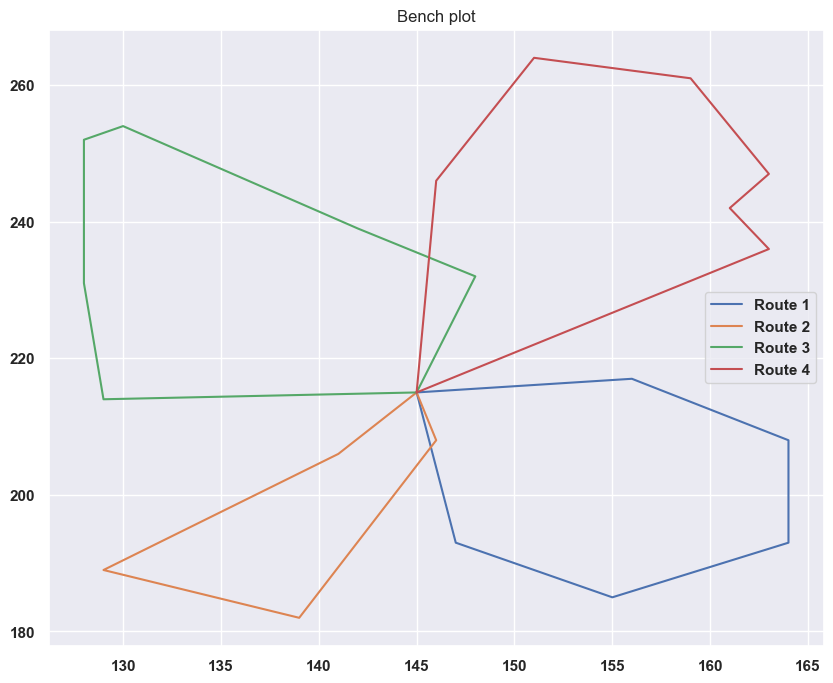

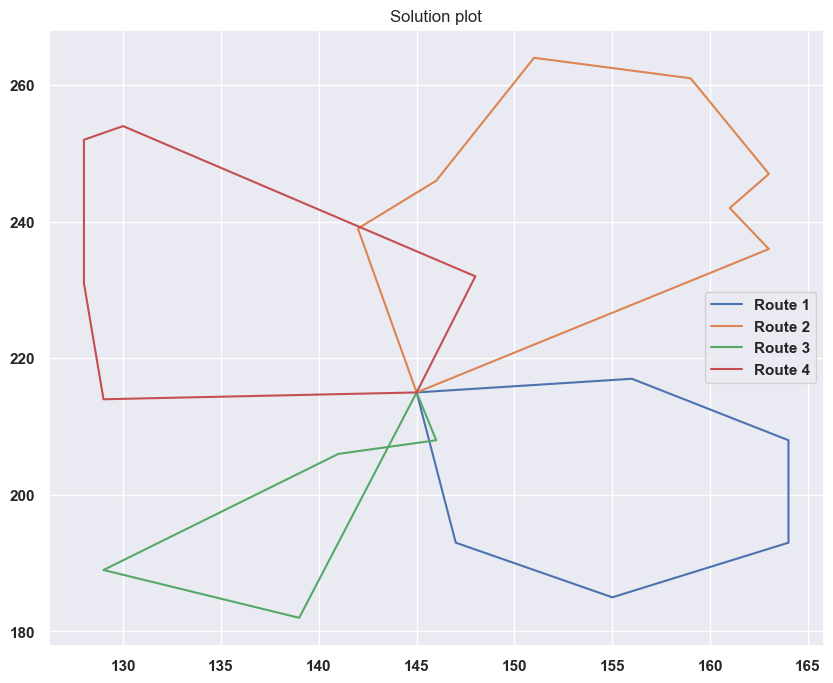

In [162]:
# Проверим наши параметры на E
params =  {
            "alpha": 1,
            "beta": 2,
            "sigma": 3,
            "q": 0.8,
            "theta": 80,
            "ants": 3,
            "iterations": 5000
        }

folder = "E/"
dataset = "E-n22-k4"

colony = AntColonySolver(**params)
colony.fit(folder, dataset, verbose=500, early_stop=3000)
colony.get_best_solution()
colony.plot_solution_routes()

0: 1097
500: 774
1000: 774
1500: 767
2000: 767
2500: 767
3000: 755
3500: 755
4000: 755
4500: 755


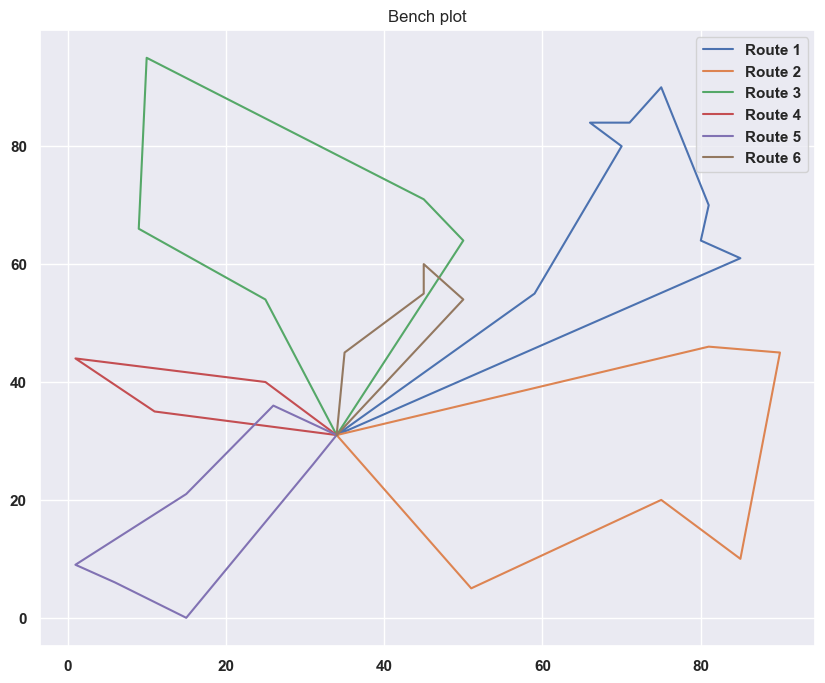

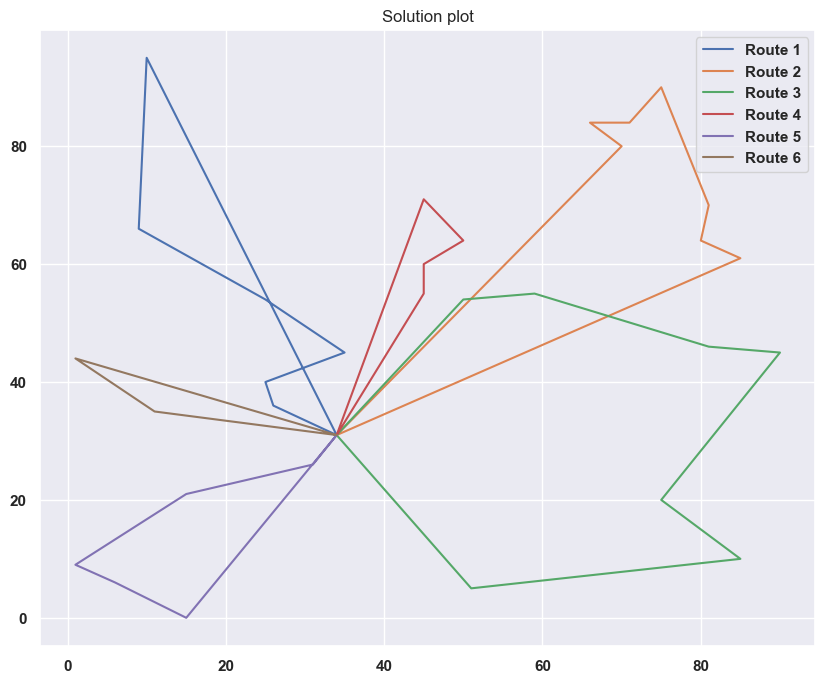

In [163]:
# Проверим наши параметры на A
params =  {
            "alpha": 1,
            "beta": 2,
            "sigma": 3,
            "q": 0.8,
            "theta": 80,
            "ants": 3,
            "iterations": 5000
        }

folder = "A/"
dataset = "A-n33-k6"

colony = AntColonySolver(**params)
colony.fit(folder, dataset, verbose=500, early_stop=3000)
colony.get_best_solution()
colony.plot_solution_routes()

0: 782
500: 684
1000: 683
1500: 679
2000: 679
2500: 679
3000: 679
3500: 679
4000: 678
4500: 678


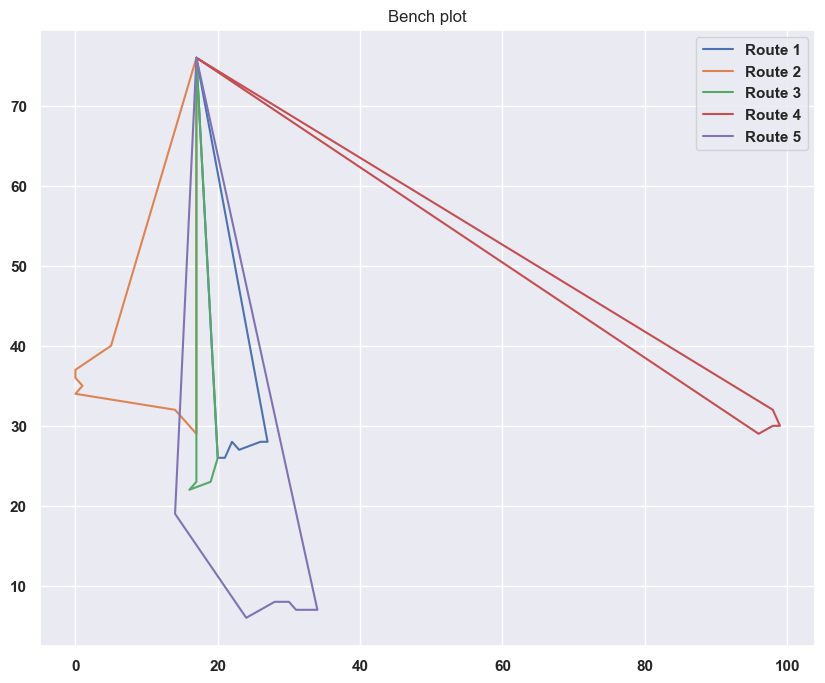

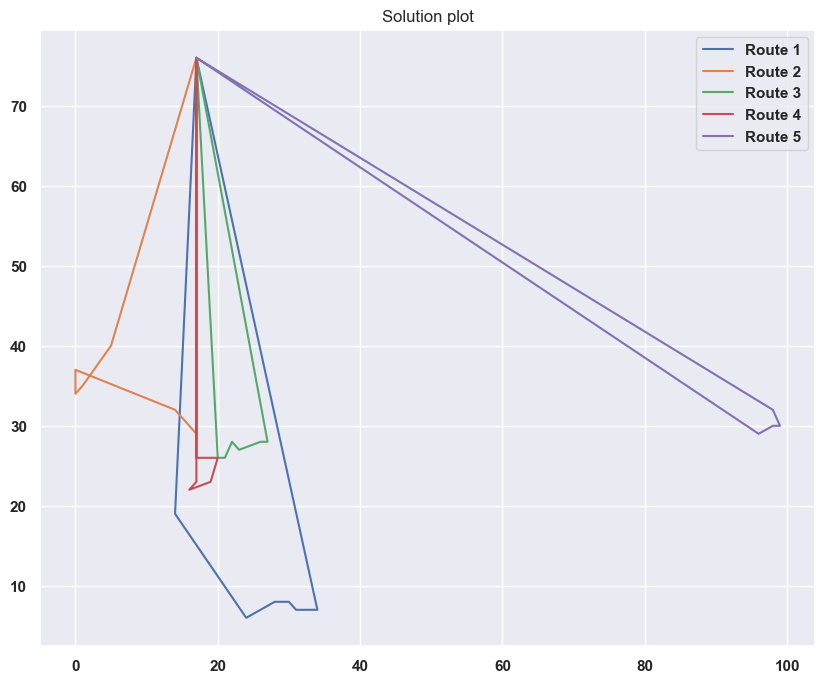

In [164]:
# Проверим наши параметры на B
params =  {
            "alpha": 1,
            "beta": 2,
            "sigma": 3,
            "q": 0.8,
            "theta": 80,
            "ants": 3,
            "iterations": 5000
        }

folder = "B/"
dataset = "B-n31-k5"

colony = AntColonySolver(**params)
colony.fit(folder, dataset, verbose=500, early_stop=3000)
colony.get_best_solution()
colony.plot_solution_routes()